In [61]:
import os
from Crypto.Cipher import AES
from math import ceil
from hashlib import sha256
from tqdm import tqdm
from time import time
from matplotlib import pyplot as plt
% matplotlib inline

## Реализация AesBlockEncrypt

In [2]:
octet_size = 8
bytes_order = 'big'
aes_block_size = 16
aes_key_allowed_lenghts = (16, 24, 32)

In [3]:
def aes_block_encrypt(key, message, is_final_block=False, padding=0):
    if type(key) is not bytes:
        raise TypeError("Key's type should be bytes.")
    if type(message) is not bytes:
        raise TypeError("Message's type should be bytes.")
    if len(key) not in aes_key_allowed_lenghts:
        raise ValueError("AES key must be either 16, 24, or 32 bytes long")
    if is_final_block:
        message += padding
    if len(message) != aes_block_size:
        raise ValueError("Message's length should be equal to AES block size = 16. Use padding.")
    
    cipher = AES.new(key, AES.MODE_ECB)
    ciphertext = cipher.encrypt(message)
    return ciphertext

In [67]:
class AESBlockEnrypt:
    def __init__(self, key):
        self.cipher = AES.new(key, AES.MODE_ECB)
    def block_encrypt(self, message):
        return self.cipher.encrypt(message)

In [4]:
def xor_two_bytes(x, y):
    if len(x) != len(y):
        raise ValueError("Lengths of xored values aren't equal")
    result = bytearray()
    for i in range(len(x)):
        result.append(x[i] ^ y[i])
    return bytes(result)

## Реализация OMAC

In [65]:
class OMAC:
    def __init__(self, k):
        self.octet_size = 8
        self.bytes_order = 'big'
        self.aes_block_size = 16
        self.k0 = k
        self.aes = AESBlockEnrypt(self.k0)
        
        def extract_msb(b):
            return int(format(b[0], f'0{self.octet_size}b')[0])
        
        def left_circular_shift(b, x):
            bits_amount = len(b) * self.octet_size
            b_int = int.from_bytes(b, self.bytes_order)
            shift = (b_int << x) | (b_int >> (bits_amount - x))
            shift_str = format(shift, f'0{bits_amount}b')[-bits_amount:]
            return bytearray([int(shift_str[i:i+self.octet_size], 2) for i in range(0, len(shift_str), self.octet_size)])
        
        def make_k1_k2_from_k(k):
            # первые 15 октетов нули, в последнем '10000111', что равно 135 
            R_16 = bytearray(15) + bytearray([135]) 
            L = aes_block_encrypt(k, bytes(bytearray(self.aes_block_size)))
            if extract_msb(L) == 0:
                k1 = left_circular_shift(L, 1)
            else:
                k1 = xor_two_bytes(left_circular_shift(L, 1), R_16)
            if extract_msb(k1) == 0:
                k2 = left_circular_shift(k1, 1)
            else:
                k2 = xor_two_bytes(left_circular_shift(k1, 1), R_16)
            return k1, k2
            
        self.k1, self.k2 = make_k1_k2_from_k(k)
        
        
    def __mac_add_block(self, data_block):
        if not self.state:
            self.state = data_block
        else:
            self.state = xor_two_bytes(data_block, self.aes.block_encrypt(self.state))
        
        
    def __mac_finalize(self):
        self.state = xor_two_bytes(self.state, self.k2 if self.padding_used else self.k1)
        return self.aes.block_encrypt(self.state)
          
        
    def compute_mac(self, data):
        def add_omac_padding(b):
            padding_len = ceil(len(b) / self.aes_block_size) * self.aes_block_size - len(b)
            # 128 это '10000000'
            return b + bytearray([128] + [0] * (padding_len - 1))
        
        self.state = None # состояние перед AesBlockEncrypt
        self.padding_used = False
        
        if len(data) % self.aes_block_size != 0:
            data = add_omac_padding(data)
            self.padding_used = True
        
        for i in range(0, len(data), self.aes_block_size):
            self.__mac_add_block(data[i:i + self.aes_block_size])
            
        tag = self.__mac_finalize()
        return tag   
    
    
    def verify_mac(self, data, tag):
        return self.compute_mac(data) == tag

## Реализация truncated-MAC (64 бита)

In [69]:
class TruncatedMAC:
    def __init__(self, k):
        self.octet_size = 8
        self.bytes_order = 'big'
        self.aes_block_size = 16
        self.truncated_size = 8
        self.k0 = k
        self.aes = AESBlockEnrypt(self.k0)
        
        
    def __mac_add_block(self, data_block):
        self.state = self.aes.block_encrypt(xor_two_bytes(self.state, data_block))
        
        
    def __mac_finalize(self):
        return self.state[:self.truncated_size]
    
    
    def compute_mac(self, data):
        def add_pkcs5_padding(b):
            padding_len = self.aes_block_size - len(data) % self.aes_block_size
            return data + (chr(padding_len) * padding_len).encode()
        
        self.state = bytearray(self.aes_block_size)
        
        if len(data) % self.aes_block_size != 0:
            data = add_pkcs5_padding(data)
            
        for i in range(0, len(data), self.aes_block_size):
            self.__mac_add_block(data[i:i + self.aes_block_size])
            
        tag = self.__mac_finalize()
        return tag 
    
    
    def verify_mac(self, data, tag):
        return self.compute_mac(data) == tag

## Реализация HMAC

In [8]:
class HMAC:
    def __init__(self, key):
        self.k = key 
        self.opad = 0x5c
        self.ipad = 0x36
        self.k_xor_opad = bytearray([self.opad ^ i for i in self.k])
        self.k_xor_ipad = bytearray([self.ipad ^ i for i in self.k])
        self.block_size = 64
        
    def __mac_add_block(self, data_block):
        self.sha256_hash.update(data_block)
    
    
    def __mac_finalize(self):
        return sha256(self.k_xor_opad + self.sha256_hash.digest()).digest()
    
    
    def compute_mac(self, data):
        self.sha256_hash = sha256()
        self.sha256_hash.update(self.k_xor_ipad)
        
        for i in range(0, len(data), self.block_size):
            self.__mac_add_block(data[i:i + self.block_size])
        
        tag = self.__mac_finalize()
        return tag
    
    
    def verify_mac(self, data, tag):
        return self.compute_mac(data) == tag 

# Задание 3
Для каждого алгоритма выработки кода аутентичности вычислить и проверить для произвольного текст длины 2,5 блока

In [70]:
key = os.urandom(aes_block_size)
data = os.urandom(int(aes_block_size * 2.5))

omac = OMAC(key)
tag_omac = omac.compute_mac(data)
assert (omac.verify_mac(data, tag_omac) == True)

tr_mac = TruncatedMAC(key)
tag_tr_mac = tr_mac.compute_mac(data)
assert (tr_mac.verify_mac(data, tag_tr_mac) == True)

hmac = HMAC(key)
tag_hmac = hmac.compute_mac(data)
assert (hmac.verify_mac(data, tag_hmac) == True)

Поменять один бит в блоке - убедиться, что проверка кода аутентичности не выполняется, для модифицированных данных

In [10]:
changed_data = bytearray(data)
changed_data[0] += 1
changed_data = bytes(changed_data)

assert (omac.verify_mac(changed_data, key) == False)
assert (tr_mac.verify_mac(changed_data, key) == False)
assert (hmac.verify_mac(changed_data, key) == False)

# Задание 4
Замерить производительность OMAC и HMAC для сообщений, длины 0.1, 1, 10, 1024 KB (не менее 1000 сообщений)

In [26]:
messages_len = [100, 1000, 10000, 1024000]

In [16]:
# 1000 сообщений длиной 0.1 KB
messages_1 = [os.urandom(messages_len[0]) for _ in range(1000)]

# 1000 сообщений длиной 1 KB
messages_2 = [os.urandom(messages_len[1]) for _ in range(1000)]

# 1000 сообщений длиной 10 KB
messages_3 = [os.urandom(messages_len[2]) for _ in range(1000)]

# 1000 сообщений длиной 1024 KB
messages_4 = [os.urandom(messages_len[3]) for _ in range(1000)]

In [72]:
omac_times = []
hmac_times = []

In [90]:
start_time = time()
for message in tqdm(messages_1):
    omac.compute_mac(message)
omac_times.append(time() - start_time)

100%|██████████| 1000/1000 [00:00<00:00, 13167.98it/s]


In [91]:
start_time = time()
for message in tqdm(messages_2):
    omac.compute_mac(message)
omac_times.append(time() - start_time)

100%|██████████| 1000/1000 [00:00<00:00, 1640.59it/s]


In [92]:
start_time = time()
for message in tqdm(messages_3):
    omac.compute_mac(message)
omac_times.append(time() - start_time)

100%|██████████| 1000/1000 [00:05<00:00, 180.86it/s]


In [76]:
start_time = time()
for message in tqdm(messages_4):
    omac.compute_mac(message)
omac_times.append(time() - start_time)

100%|██████████| 1000/1000 [08:57<00:00,  1.86it/s]


In [77]:
start_time = time()
for message in tqdm(messages_1):
    hmac.compute_mac(message)
hmac_times.append(time() - start_time)

100%|██████████| 1000/1000 [00:00<00:00, 203005.86it/s]


In [78]:
start_time = time()
for message in tqdm(messages_2):
    hmac.compute_mac(message)
hmac_times.append(time() - start_time)

100%|██████████| 1000/1000 [00:00<00:00, 67372.97it/s]


In [79]:
start_time = time()
for message in tqdm(messages_3):
    hmac.compute_mac(message)
hmac_times.append(time() - start_time)

100%|██████████| 1000/1000 [00:00<00:00, 9500.27it/s]


In [80]:
start_time = time()
for message in tqdm(messages_4):
    hmac.compute_mac(message)
hmac_times.append(time() - start_time)

100%|██████████| 1000/1000 [00:10<00:00, 97.55it/s]


### ❗️То, что теперь объект AES создается 1 раз, а не много-много раз, существенно снизило время выполнения OMAC
Для 1000 1024 KB сообщений 22 мин -> 9 мин

In [94]:
print(omac_times)
print(hmac_times)

[0.07813191413879395, 0.6117300987243652, 5.531458854675293, 537.6261529922485]
[0.007134914398193359, 0.01707601547241211, 0.10743880271911621, 10.253053188323975]


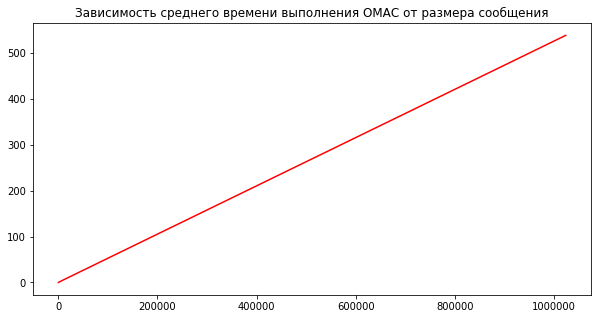

In [95]:
plt.figure(figsize=(10, 5))
plt.title('Зависимость среднего времени выполнения OMAC от размера сообщения')
plt.plot(messages_len, omac_times, color='r')
plt.savefig('omac_stats.png')
plt.show()

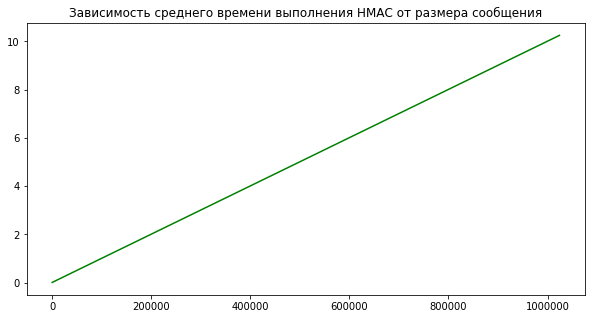

In [96]:
plt.figure(figsize=(10, 5))
plt.title('Зависимость среднего времени выполнения HMAC от размера сообщения')
plt.plot(messages_len, hmac_times, color='g')
plt.savefig('hmac_stats.png')
plt.show()